# Project: Predicting Stock Price & Return  
Feature Creation and Random Forest Classifier
## ver 0.4  
All guidance and guildlines provided by Romeo Kienzler

### Guidance - Feature Creation  
This task transforms input columns of various relations into additional columns to improve model performance. A subset of those features can be created in an initial task (for example, one-hot encoding of categorical variables or normalization of numerical variables). Some others require business understanding or multiple iterations to be considered. This task is one of those benefiting the most from the highly iterative nature of this method.

### Guildlines for feature transformation  
- Imputing  
Some algoriths are very sensitive to missing values. Therefore, imputing allows for filling of empty fields based on its value distribution  
- Imputed time-seies quantization  
Time series often contain streams with measurements at different timestamps. Therefore, it is beneficial to quantize measurements to a common "heart beat: and impute the corresponding values. This can be done by sampling from the source time series distributions on the respective quantized time steps  
- Scaling / Normalizing / Centering  
Some algorithms are very sensitive differences in value ranges for individual fields. Therefore, it is best practice to center data around zero and scale values to a standard deviation of one  
- Filtering  
Sometimes imputing values doesn't perform well, therefore deletion of low quality records is a better strategy  
- Discretizing  
Continuous fileds might confuse the model, e.g. a discrete set of age ranges sometimes performs better than continuous values, especially on smaller amounts of data and with simpler models

### Guildlines for feature creation  
- One-hot-enconding  
Categorical integer features should be transformed into "one-hot" vectors. In relational terms this results in additional columns - one columns for each distinct category  
- Time-to-Frequency transformation  
Time-series (and sometimes also sequence data) is recorded in the time domain but can easily transformed into the frequency domain e.g. using FFT (Fast Fourier transformation)  
- Month-From-Date  
Creating an additional feature containing the month independent from data captures seasonal aspects. Sometimes further discretization in to quarters helps as well  
- Aggregate-on-Target  
Simply aggregating fields the target variable (or even other fields) can improve performance, e.g. count number of data points per ZIP code or take the median of all values by geographical region

#### 0.Import packages

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import talib

In [36]:
#let the notebook display full length of the data columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

#### 1. Create target

In [37]:
df = pd.read_csv("data_transformed.csv", parse_dates=['date'], index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4356 entries, 2003-01-02 to 2019-10-18
Data columns (total 21 columns):
loblaw_price           4356 non-null float64
loblaw_volume          4356 non-null float64
metro_price            4356 non-null float64
metro_volume           4356 non-null float64
empa_price             4356 non-null float64
empa_volume            4356 non-null float64
gwl_price              4356 non-null float64
gwl_volume             4356 non-null float64
atd_price              4356 non-null float64
atd_volume             4356 non-null float64
tsx_price              4356 non-null float64
tsx_volume             4356 non-null float64
sp500_price            4356 non-null float64
sp500_volume           4356 non-null float64
BCPI                   4356 non-null float64
CPI                    4356 non-null float64
bank_interest          4356 non-null float64
CEER                   4356 non-null float64
trend_grocery_store    4104 non-null float64
trend_loblaws       

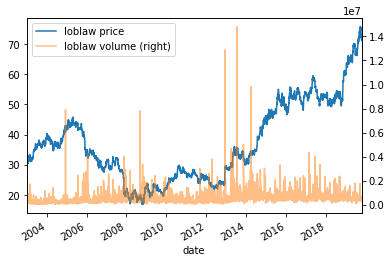

In [38]:
df['loblaw_price'].plot(label = 'loblaw price', legend = True)
df['loblaw_volume'].plot(secondary_y=True, alpha=0.5, label = 'loblaw volume' , legend = True)
plt.show()

In [99]:
df['loblaw_5d_future'] = df['loblaw_price'].shift(-5)
df['loblaw_5d_future_pct'] = df['loblaw_5d_future'].pct_change(5)
df['loblaws_5d_return_level'] = pd.qcut(df['loblaw_5d_future_pct'], 5, labels=False) - 2


In [100]:
_ =
'''
Q1 = df['loblaw_5d_future_pct'].quantile(0.25)
Q3 = df['loblaw_5d_future_pct'].quantile(0.75)
IQR = Q3 - Q1

df['loblaws_5d_return_level'] = df['loblaw_5d_future_pct'].apply(lambda x: -2 if x < (Q1 - 1.5 * IQR) 
                                                                else -1 if (Q1 - 1.5 * IQR) < x < Q1
                                                                else 0  if Q1 < x < Q3
                                                                else 1  if Q3 < x < (Q3 + 1.5 * IQR) 
                                                                else 2)
                                                            
'''

"\nQ1 = df['loblaw_5d_future_pct'].quantile(0.25)\nQ3 = df['loblaw_5d_future_pct'].quantile(0.75)\nIQR = Q3 - Q1\n\ndf['loblaws_5d_return_level'] = df['loblaw_5d_future_pct'].apply(lambda x: -2 if x < (Q1 - 1.5 * IQR) \n                                                                else -1 if (Q1 - 1.5 * IQR) < x < Q1\n                                                                else 0  if Q1 < x < Q3\n                                                                else 1  if Q3 < x < (Q3 + 1.5 * IQR) \n                                                                else 2)\n                                                            \n"

In [101]:
df.loblaws_5d_return_level.value_counts()

 1.0    819
 2.0    819
-1.0    819
-2.0    819
 0.0    818
Name: loblaws_5d_return_level, dtype: int64

In [102]:
feature_names = []
stock_list = ['loblaw', 'metro', 'gwl', 'empa', 'atd', 'tsx', 'sp500']
for stock in stock_list:
    for n in [14, 30, 50, 200]:
        df[stock + '_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
        df[stock + '_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
        feature_names = feature_names + [stock + '_ma' + str(n), stock + '_rsi' + str(n)]
    
    df[stock + '_5d_pct'] = df[stock + '_price'].pct_change(5)
    feature_names = feature_names + [stock + '_5d_pct']
    feature_names = feature_names + [stock + '_price']

    df[stock + '_volume_1d_pct_SMA'] = talib.SMA(df[stock + '_volume'].pct_change().values, timeperiod=5)
    feature_names = feature_names + [stock + '_volume_1d_pct_SMA']


In [103]:
df.dropna(inplace=True)

In [104]:
df.shape

(3894, 94)

In [105]:
df.head()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-10-19,38.9513,327100.0,3.6801,626400.0,5.3319,62808.0,72.7530,57300.0,1.6219,485424.0,8720.5000,121747700.0,1103.23,1.737500e+09,432.696,105.428571,4.20,116.82,43.714286,29.857143,13.142857,39.2854,0.008577,1.0,0.981106,62.817711,0.976274,58.664453,0.954464,55.725134,0.958974,48.977253,0.022392,0.162791,0.981106,62.817711,0.976274,58.664453,0.954464,55.725134,0.958974,48.977253,-0.005190,1.653719,0.981106,62.817711,0.976274,58.664453,0.954464,55.725134,0.958974,48.977253,0.017623,0.450727,0.981106,62.817711,0.976274,58.664453,0.954464,55.725134,0.958974,48.977253,0.016646,0.517364,0.981106,62.817711,0.976274,58.664453,0.954464,55.725134,0.958974,48.977253,-0.004969,0.533688,0.981106,62.817711,0.976274,58.664453,0.954464,55.725134,0.958974,48.977253,-0.007444,0.055977,0.981106,62.817711,0.976274,58.664453,0.954464,55.725134,0.958974,48.977253,-0.016589,0.067810
2004-10-20,38.9274,291500.0,3.7359,1100700.0,5.3356,15828.0,72.8849,68400.0,1.6126,659868.0,8788.0996,137795100.0,1103.66,1.685700e+09,433.300,105.447619,4.25,117.68,43.523810,29.761905,13.238095,39.2615,0.008583,1.0,0.982058,62.450306,0.978391,58.504014,0.956517,55.631620,0.959430,48.956517,0.024332,0.084283,0.982058,62.450306,0.978391,58.504014,0.956517,55.631620,0.959430,48.956517,0.007253,1.581600,0.982058,62.450306,0.978391,58.504014,0.956517,55.631620,0.959430,48.956517,0.018529,-0.008340,0.982058,62.450306,0.978391,58.504014,0.956517,55.631620,0.959430,48.956517,-0.004608,0.221848,0.982058,62.450306,0.978391,58.504014,0.956517,55.631620,0.959430,48.956517,-0.000991,0.659542,0.982058,62.450306,0.978391,58.504014,0.956517,55.631620,0.959430,48.956517,0.006701,-0.005560,0.982058,62.450306,0.978391,58.504014,0.956517,55.631620,0.959430,48.956517,-0.008971,0.027593
2004-10-21,39.4942,211600.0,3.7090,81900.0,5.3603,29097.0,72.4673,75000.0,1.5724,1375536.0,8846.7002,132834800.0,1106.49,1.673000e+09,437.354,105.466667,4.25,117.62,43.333333,29.666667,13.333333,39.3033,-0.004834,-1.0,0.969529,67.330348,0.966359,61.113125,0.944507,57.363102,0.945613,49.466458,0.039247,0.022522,0.969529,67.330348,0.966359,61.113125,0.944507,57.363102,0.945613,49.466458,0.015803,1.559126,0.969529,67.330348,0.966359,61.113125,0.944507,57.363102,0.945613,49.466458,0.008461,0.096105,0.969529,67.330348,0.966359,61.113125,0.944507,57.363102,0.945613,49.466458,0.008922,0.542185,0.969529,67.330348,0.966359,61.113125,0.944507,57.363102,0.945613,49.466458,-0.031117,0.391177,0.969529,67.330348,0.966359,61.113125,0.944507,57.363102,0.945613,49.466458,0.011560,0.023734,0.969529,67.330348,0.966359,61.113125,0.944507,57.363102,0.945613,49.466458,0.002900,0.033420
2004-10-22,39.3450,139800.0,3.6993,136500.0,5.3603,22329.0,71.7861,26000.0,1.5512,565164.0,8780.7998,10772820

In [106]:
df.tail()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-30,75.46,463100.0,58.33,530100.0,35.7487,450567.0,111.46,210800.0,40.60,1718934.0,16658.5996,200791800.0,2976.7400,3.247610e+09,432.33,136.8,3.95,118.00,80.465116,34.069767,64.232558,75.11,-0.004638,0.0,0.979000,67.060722,0.968949,64.956617,0.944830,62.844580,0.886344,58.252814,0.005463,-0.054491,0.979000,67.060722,0.968949,64.956617,0.944830,62.844580,0.886344,58.252814,0.013553,0.171493,0.979000,67.060722,0.968949,64.956617,0.944830,62.844580,0.886344,58.252814,-0.005443,0.078956,0.979000,67.060722,0.968949,64.956617,0.944830,62.844580,0.886344,58.252814,-0.003334,0.251209,0.979000,67.060722,0.968949,64.956617,0.944830,62.844580,0.886344,58.252814,-0.017187,0.058828,0.979000,67.060722,0.968949,64.956617,0.944830,62.844580,0.886344,58.252814,-0.012367,0.040167,0.979000,67.060722,0.968949,64.956617,0.944830,62.844580,0.886344,58.252814,-0.005027,0.010876
2019-10-01,74.81,413800.0,57.63,798300.0,35.9281,421071.0,110.59,221500.0,40.18,1620315.0,16447.6992,225195700.0,2940.2500,3.558040e+09,432.33,136.8,3.95,118.04,80.000000,34.000000,64.000000,74.03,-0.010426,-1.0,0.989870,60.864919,0.978648,61.925527,0.955242,60.997321,0.895061,57.775031,-0.012670,-0.037940,0.989870,60.864919,0.978648,61.925527,0.955242,60.997321,0.895061,57.775031,-0.012847,0.112069,0.989870,60.864919,0.978648,61.925527,0.955242,60.997321,0.895061,57.775031,-0.020547,0.096683,0.989870,60.864919,0.978648,61.925527,0.955242,60.997321,0.895061,57.775031,-0.021179,0.053489,0.989870,60.864919,0.978648,61.925527,0.955242,60.997321,0.895061,57.775031,-0.029234,0.004813,0.989870,60.864919,0.978648,61.925527,0.955242,60.997321,0.895061,57.775031,-0.020871,0.018488,0.989870,60.864919,0.978648,61.925527,0.955242,60.997321,0.895061,57.775031,-0.008882,-0.012784
2019-10-02,74.88,358800.0,58.05,669800.0,36.1374,385020.0,110.73,187400.0,40.40,1149138.0,16311.0000,218200100.0,2887.6101,3.912520e+09,432.33,136.8,3.95,117.52,80.000000,34.000000,64.000000,74.15,-0.009749,-1.0,0.991463,61.279812,0.979066,62.122436,0.956481,61.122899,0.895226,57.812482,-0.010571,-0.038062,0.991463,61.279812,0.979066,62.122436,0.956481,61.122899,0.895226,57.812482,-0.008031,0.144757,0.991463,61.279812,0.979066,62.122436,0.956481,61.122899,0.895226,57.812482,-0.021560,-0.001794,0.991463,61.279812,0.979066,62.122436,0.956481,61.122899,0.895226,57.812482,-0.005488,0.075694,0.991463,61.279812,0.979066,62.122436,0.956481,61.122899,0.895226,57.812482,-0.014514,-0.099485,0.991463,61.279812,0.979066,62.122436,0.956481,61.122899,0.895226,57.812482,-0.028199,0.021772,0.991463,61.279812,0.979066,62.122436,0.956481,61.122899,0.895226,57.812482,-0.032584,0.035542
2019-10-03,75.20,474500.0,58.00,976400.0,36.6756,1192967.0,111.07,183800.0,41.22,3018224.0,16369.0000,23788310

In [107]:
economic_indecis = ['BCPI', 'CPI', 'bank_interest', 'CEER']
google_trends = ['trend_grocery_store', 'trend_loblaws', 'trend_stock']
feature_names = feature_names + economic_indecis + google_trends
print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_5d_pct', 'loblaw_price', 'loblaw_volume_1d_pct_SMA', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_5d_pct', 'metro_price', 'metro_volume_1d_pct_SMA', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_5d_pct', 'gwl_price', 'gwl_volume_1d_pct_SMA', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_5d_pct', 'empa_price', 'empa_volume_1d_pct_SMA', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_5d_pct', 'atd_price', 'atd_volume_1d_pct_SMA', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_5d_pct', 'tsx_price', 'tsx_volume_1d_pct_SMA', 'sp500_ma

In [108]:
features = df[feature_names]
targets = df[['loblaws_5d_return_level']].values.ravel()

In [109]:
train_size = int(0.75 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [110]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(2920, 84) (2920,)
(974, 84) (974,)


In [111]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [112]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,8,16,32,64], 'random_state': [42]}
test_scores = []
rfc = RandomForestClassifier()

for g in ParameterGrid(grid):
    rfc.set_params(**g)  
    rfc.fit(train_features, train_targets)
    test_scores.append(rfc.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.17761806981519507 {'random_state': 42, 'n_estimators': 200, 'max_features': 64, 'max_depth': 3}


In [120]:
rfc= RandomForestClassifier(n_estimators=200, max_features=64, max_depth=3, random_state=42)
rfc.fit(train_features, train_targets)
print(rfc.score(train_features, train_targets))
print(rfc.score(test_features, test_targets))

predicts = rfc.predict(test_features)

0.38595890410958905
0.17761806981519507


In [121]:
np.unique(test_targets, return_counts=True)

(array([-2., -1.,  0.,  1.,  2.]), array([127, 203, 260, 210, 174]))

In [122]:
np.unique(predicts, return_counts=True)

(array([-2., -1.,  1.,  2.]), array([603,  31, 215, 125]))

In [123]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

/home/paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


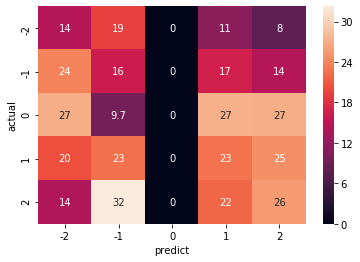

In [128]:
cm = confusion_matrix(test_targets, predicts)
sns.heatmap(100 * np.nan_to_num(cm / cm.sum(axis=0)), annot=True, xticklabels=[-2,-1,0,1,2],yticklabels=[-2,-1,0,1,2])
plt.xlabel('predict')
plt.ylabel('actual')
plt.show()

In [130]:
cm.sum(axis=1)

array([127, 203, 260, 210, 174])

In [131]:
cm

array([[ 87,   6,   0,  24,  10],
       [144,   5,   0,  36,  18],
       [164,   3,   0,  59,  34],
       [123,   7,   0,  49,  31],
       [ 85,  10,   0,  47,  32]])

In [118]:
np.unique(predicts, return_counts=True)

(array([-2., -1.,  1.,  2.]), array([665,  58, 145, 106]))

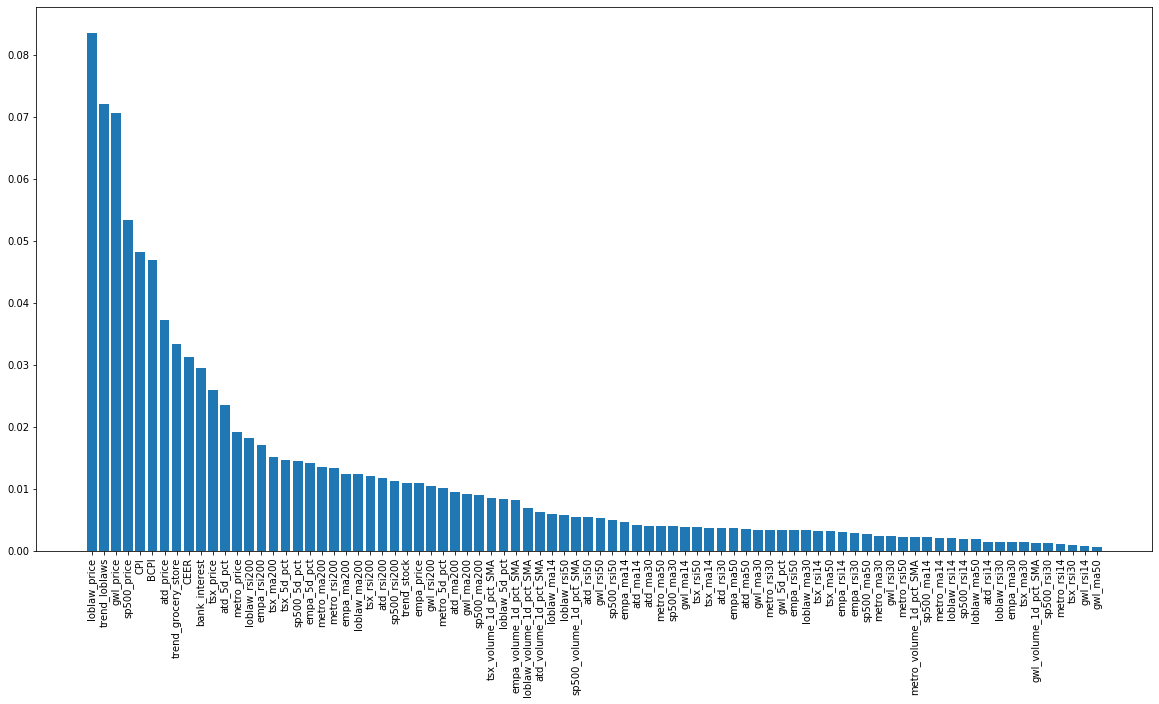

In [119]:
# Get feature importances from our random forest model
importances = rfc.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.figure(figsize=(20,10))
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [28]:
less_features = ['loblaw_price', 'gwl_price', 'sp500_price', 'CPI', 'trend_loblaws']

In [29]:
features = df[less_features]
targets = df[['loblaws_5d_return_level']].values.ravel()

In [30]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [31]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(3484, 5) (3484,)
(615, 5) (615,)


In [32]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [3,5], 'random_state': [42]}
test_scores = []
rfc = RandomForestClassifier()

for g in ParameterGrid(grid):
    rfc.set_params(**g)  
    rfc.fit(train_features, train_targets)
    test_scores.append(rfc.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.24552845528455283 {'random_state': 42, 'n_estimators': 200, 'max_features': 5, 'max_depth': 3}


In [33]:
rfc= RandomForestClassifier(n_estimators=200, max_features=5, max_depth=3, random_state=42)
rfc.fit(train_features, train_targets)
print(rfc.score(train_features, train_targets))
print(rfc.score(test_features, test_targets))

predicts = rfc.predict(test_features)

0.31974741676234214
0.24552845528455283


In [34]:
confusion_matrix(test_targets, predicts)

array([[ 0, 39, 43,  2,  0],
       [ 0, 46, 83,  8,  0],
       [ 0, 57, 98,  6,  0],
       [ 0, 51, 67,  7,  0],
       [ 0, 46, 59,  3,  0]])

In [132]:
df.to_csv("data_feature_created.csv")